# Bayesian Tennis Simulation

### Simulation notebook for the paper 
**“Humans can learn bimodal priors in complex sensorimotor behaviour”**  
*Zahno, Beck, Hossner, & Kording*

**Experiment:** 
- Subjects (N=24) return tennis serves in XR on 3 days
- 3 days x 480 trials = 1,440 trials
- We control the ball locations (i.e., true stimulus) 🡪 bimodal distribution (mixture of Gaussians)
- We manipulate uncertainty of sensory information 🡪 3 levels of ball speeds: slow, moderate, fast

_Last updated: November 18, 2025_

_Python version: 3.10.13_

---

### Goal

This notebook simulates participants’ responses for each trial of the experiment using Bayesian integration of **prior** and **likelihood**.  

The modelling procedure follows standard Bayesian inference steps and draws on the Neuromatch Academy Bayesian Statistics tutorial (<https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/NMA2020/tutorials/W2D1_BayesianStatistics/student/W2D1_Tutorial3.ipynb>).

In the last step, we add an extended model that combines the expected effect of the acquired bimodal prior (Bayesian simulations) and a bias caused by biomechanical costs (based on data from a control experiment)

---

## Steps in Bayesian Modelling

Reference: <http://www.cns.nyu.edu/malab/bayesianbook.html>

### **Step 1 — Specifying the Generative Model**
- **Stimulus distribution,** 
$
p(x)
$ 

  Probabilities of true ball positions. A mixture-of-Gaussians distribution defined by the experimental design.
- **Measurement distribution,** 
$
p( \tilde{x} \mid x)
$ 

  Distribution of measurements/encodings ($\tilde{x}$) given true stimulus (x) at any given trial. The variance of this distribution (i.e. the sensory noise level) depends on the ball-velocity condition (slow / moderate / fast).

### **Step 2 — Describing how the observer performs inference (i.e., inverting the generative model)**

- Combine the **prior** and **likelihood** using Bayes’ rule to compute the **posterior**,
$
p(x \mid \tilde{x}) = \frac{p(\tilde{x} \mid x)\, p(x)}{p(\tilde{x})}
$

- The model reads out the mean posterior estimate (MPE) as the participant’s internal estimate on each trial.

### **Step 3 — Response Distribution**

- For every trial, compute the probability of the participant making each possible decision given the stimuli on the trial
$
p( \hat x \mid x)
$ 

---

## Outputs of This Notebook
- **`predicted_responses` dataframe:**  
  Trial-by-trial Bayesian response predictions
- **Bayesian prediction plot:**  (`plot_3_uncertainty_levels`)   
Estimation Error vs. True Ball Position, shown separately for each uncertainty condition (slow / moderate / fast).


Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Helper functions

In [2]:
# Define gaussian function
def gaussian(x_points, mu, sigma):
    """
    Returns a Gaussian estimated at points `x_points`, with parameters: `mu` and `sigma`

    Args :
      x_points (numpy arrays of floats)- points at which the gaussian is evaluated
      mu (scalar) - mean of the Gaussian
      sigma (scalar) - std of the Gaussian

    Returns:
      Gaussian evaluated at `x`
    """
    p = np.exp(-(x_points-mu)**2/(2*sigma**2))
    return p / sum(p)

# Define mean_median_mode function
def mean_median_mode(x_points, function):
  """
  Returns the mean, median and mode of an arbitrary function

  Args :
    x_points (numpy array of floats) - x-axis values
    function (numpy array of floats) - y-axis values of the function evaluated at `x_points`

  Returns:
    (tuple of 3 scalars): mean, median, mode
  """

  # Calc mode of arbitrary function
  mode = x_points[np.argmax(function)]

  # Calc mean of arbitrary function
  mean = np.sum(x_points * function)

  # Calc median of arbitrary function
  cdf_function = np.zeros_like(x_points)
  accumulator = 0
  for i in np.arange(x_points.shape[0]):
    accumulator = accumulator + function[i]
    cdf_function[i] = accumulator
  idx = np.argmin(np.abs(cdf_function - 0.5))
  median = x_points[idx]

  return mean, median, mode

# Define plot array function
def plot_array_heatmap(array, xlabel, ylabel, title):
  """ Plot an array with labels.

  Args :
    array (numpy array of floats)
    xlabel (string) - label of x-axis
    ylabel (string) - label of y-axis
    title  (string) - title of plot

  Returns:
    None
  """
  fig = plt.figure()
  ax = fig.add_subplot(111)
  colormap = ax.imshow(array, extent=[40, 100, 100, 40])
  cbar = plt.colorbar(colormap, ax=ax)
  cbar.set_label('probability')
  ax.invert_yaxis()
  ax.set_xlabel(xlabel)
  ax.set_title(title)
  ax.set_ylabel(ylabel)
  ax.set_aspect('auto')
  return None

# Define compute posterior function
def compute_posterior_pointwise(prior, likelihood):
  "multiply the prior and likelihood"
  posterior = prior * likelihood
  "normalize the posterior"
  posterior /= posterior.sum()

  return posterior

# Define bimodal prior function
def bimodal_prior(x, mu_1_prior, sigma_1_prior, mu_2_prior, sigma_2_prior):

  prior = gaussian(x, mu_1_prior, sigma_1_prior) + gaussian(x, mu_2_prior, sigma_2_prior)
  prior /= prior.sum()

  return prior

# Define posterior plot function
def posterior_plot(x, prior=None, likelihood=None, posterior_pointwise=None, ax=None):
    """
    Plots normalized Gaussian distributions and posterior

    Args:
        x (numpy array of floats):         points at which the likelihood has been evaluated
        prior (numpy array of floats):  normalized probabilities for prior likelihood evaluated at each `x`
        likelihood(numpy array of floats):    normalized probabilities for likelihoodlikelihood evaluated at each `x`
        posterior (numpy array of floats): normalized probabilities for the posterior evaluated at each `x`
        ax: Axis in which to plot. If None, create new axis.

    Returns:
        Nothing.
    """
    if likelihood is None:
        likelihood = np.zeros_like(x)

    if prior is None:
        prior = np.zeros_like(x)

    if posterior_pointwise is None:
        posterior_pointwise = np.zeros_like(x)

    if ax is None:
      fig, ax = plt.subplots()

    ax.plot(x, prior, '-C2', label='Prior')
    ax.plot(x, likelihood, '-C1', label='Likelihood')
    ax.plot(x, posterior_pointwise, '-C0', label='Posterior')
    ax.legend()
    ax.set_ylabel('Probability')
    ax.set_xlabel('Ball locations (m)')

    return ax

## Simulate a single trial of tennis return based on bimodal prior and likelihood
This is just to get a feeling: see how changing the prior and likelihood influences the posterior

(np.float64(56.10000000000023), np.float64(56.098468313584654))

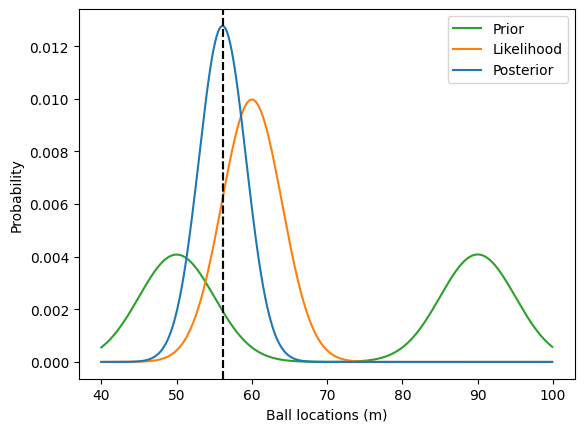

In [3]:
def bimodal_tennis_return(mu_1_prior, sigma_1_prior, mu_2_prior, sigma_2_prior, mu_likelihood, sigma_likelihood):

  # ball_positions = "true stimulus"
  x = np.arange(40, 100, 0.1)

  prior = bimodal_prior(x, mu_1_prior, sigma_1_prior, mu_2_prior, sigma_2_prior)
  likelihood = gaussian(x, mu_likelihood, sigma_likelihood)
  posterior = compute_posterior_pointwise(prior, likelihood)

  return x, prior, likelihood, posterior

# set prior
mu_1_prior= 50
sigma_1_prior= 5
mu_2_prior= 90
sigma_2_prior=5
# set likelihood
mu_likelihood = 60
sigma_likelihood = 4

# compute posterior
x, prior, likelihood, posterior_pointwise = bimodal_tennis_return(mu_1_prior, sigma_1_prior, mu_2_prior, sigma_2_prior, mu_likelihood, sigma_likelihood)
posterior_plot(x, prior, likelihood, posterior_pointwise)

# Read out mode and mean of the posterior
mode_posterior = x[np.argmax(posterior_pointwise)]
mean_posterior = np.sum(x*posterior_pointwise)

# plot a vertical line at the mode and mean
plt.axvline(mode_posterior, color='black', linestyle='--', label='Mode')
plt.axvline(mean_posterior, color='black', linestyle='--', label='Mean')

mode_posterior, mean_posterior

----

# Simulate tennis experiment


Overview
- Prior fixed at mu_1 = 50, sigma_1 = 5, and mu_2 = 90, sigma_1 = 5

- Iterate through all true ball positions (x_true) defined in the experimental protocol

- Sigma of likelihood depends on uncertainty condition. Default: slow = 1, medium = slow *4, fast = slow *10

- Likelihood array -> Likelihood for every possible "encoding"/"measurement" of x
- Posterior array -> Posterior for every possible "encoding"/"measurement" of x

- Marginalize to obtain the response distribution

- **Estimation error:**  
  For each trial, compute 

  $
  \text{estimation error} = \text{true stimulus} - \text{estimated response}
  $  

  and store it in a new column.

## Import experimental protocol

- relevant columns = trial_id, condition (slow/moderate/fast), ball_positions (="true_stimulus")
- 480 trials in total: 160 for each uncertainty condition (slow/moderate/fast)
- same distribution of ball_positions for every uncertainty condition


In [4]:
# Import excel file vr_tennis_exp_fs24_protocol_day3
experimental_protocol = pd.read_excel('../experimental_protocols/vr_tennis_exp_fs24_protocol_day3.xlsx')

### Before starting the tennis simulation, the relevant functions are created and illustrated with plots

## (1) Function to generate likelihood array

- Creates likelihoods for all potential "encodings/observations/measurements" of x_true (ball position) at a given trial
- Each likelihood will have a different mean; likelihood array made up of 1,000 row-Gaussians

<>:20: SyntaxWarning: invalid escape sequence '\~'
<>:21: SyntaxWarning: invalid escape sequence '\~'
<>:20: SyntaxWarning: invalid escape sequence '\~'
<>:21: SyntaxWarning: invalid escape sequence '\~'
C:\Users\beck\AppData\Local\Temp\ipykernel_21988\744032834.py:20: SyntaxWarning: invalid escape sequence '\~'
  'Brain encoded stimulus location $\~x$',
C:\Users\beck\AppData\Local\Temp\ipykernel_21988\744032834.py:21: SyntaxWarning: invalid escape sequence '\~'
  'Likelihood as a function of $\~x$ : $p(\~x | x)$')


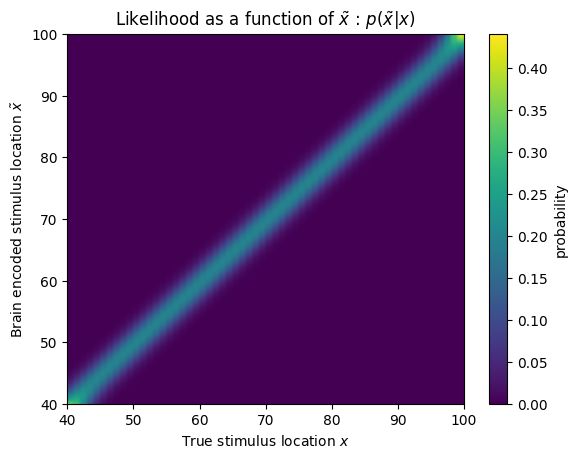

In [5]:
x = np.arange(40, 100, 1)
hypothetical_stim = np.linspace(40, 100, 1000)

def compute_likelihood_array(x_points, stim_array, sigma):

    # initializing likelihood_array
    likelihood_array = np.zeros((len(stim_array), len(x_points)))

    # looping over stimulus array
    for i in range(len(stim_array)):
        likelihood_array[i, :] = gaussian(x_points, stim_array[i], sigma)

    return likelihood_array

sigma = 2
likelihood_array = compute_likelihood_array(x, hypothetical_stim, sigma)

plot_array_heatmap(likelihood_array,
              'True stimulus location $x$',
              'Brain encoded stimulus location $\~x$',
              'Likelihood as a function of $\~x$ : $p(\~x | x)$')

## (2) Function to generate bimodal prior array (again plotted as function of "all potential encodings of x")

<>:14: SyntaxWarning: invalid escape sequence '\~'
<>:15: SyntaxWarning: invalid escape sequence '\~'
<>:14: SyntaxWarning: invalid escape sequence '\~'
<>:15: SyntaxWarning: invalid escape sequence '\~'
C:\Users\beck\AppData\Local\Temp\ipykernel_21988\1864149922.py:14: SyntaxWarning: invalid escape sequence '\~'
  'Brain encoded stimulus location $\~x$',
C:\Users\beck\AppData\Local\Temp\ipykernel_21988\1864149922.py:15: SyntaxWarning: invalid escape sequence '\~'
  'Prior as a function of $\~x$ : $p(x|\~x)$')


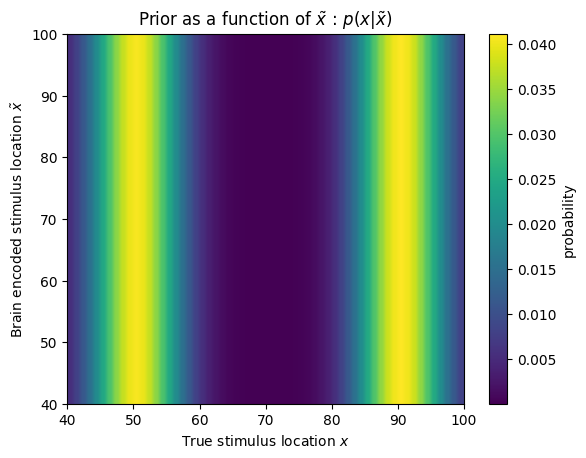

In [6]:
def calculate_bimodal_prior_array(x_points, stim_array, mu_1_prior= 50, sigma_1_prior= 5, mu_2_prior= 90, sigma_2_prior=5):

    prior_mixed = gaussian(x_points, mu_1_prior, sigma_1_prior) + gaussian(x, mu_2_prior, sigma_2_prior)
    prior_mixed /= prior_mixed.sum() # normalize

    prior_array = np.tile(prior_mixed, len(stim_array)).reshape(len(stim_array), -1)
    return prior_array

prior_array = calculate_bimodal_prior_array(x, hypothetical_stim)


plot_array_heatmap(prior_array,
               'True stimulus location $x$', 
               'Brain encoded stimulus location $\~x$',
               'Prior as a function of $\~x$ : $p(x|\~x)$')

##  (3) Function to calculate posterior (again as a function of "all potential encodings of x")

- Takes likelihood and a prior for each brain encoded position  $\~x$ (part 1 and 2), and multiplies them row-wise
- That is, each row of the posterior array will be the posterior resulting from the multiplication of the prior and likelihood of the same equivalent row.

<>:12: SyntaxWarning: invalid escape sequence '\~'
<>:13: SyntaxWarning: invalid escape sequence '\~'
<>:12: SyntaxWarning: invalid escape sequence '\~'
<>:13: SyntaxWarning: invalid escape sequence '\~'
C:\Users\beck\AppData\Local\Temp\ipykernel_21988\2881720857.py:12: SyntaxWarning: invalid escape sequence '\~'
  'Brain encoded stimulus location $\~x$',
C:\Users\beck\AppData\Local\Temp\ipykernel_21988\2881720857.py:13: SyntaxWarning: invalid escape sequence '\~'
  'Posterior as a function of $\~x$ : $p(x | \~x)$')


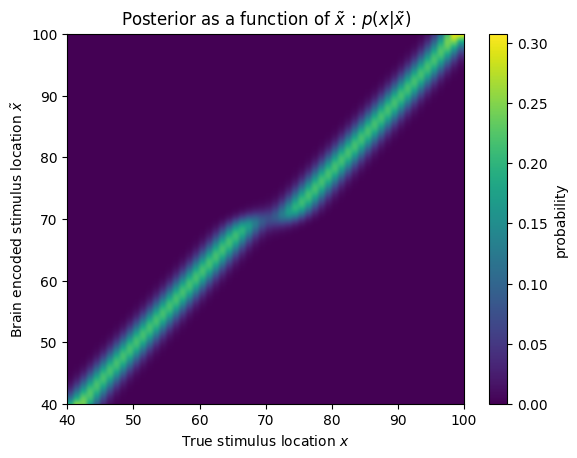

In [7]:
def calculate_posterior_array(prior_array, likelihood_array):

    posterior_array = prior_array * likelihood_array
    posterior_array /= posterior_array.sum(axis=1, keepdims=True)  # normalize each row separately

    return posterior_array

posterior_array = calculate_posterior_array(prior_array, likelihood_array)

plot_array_heatmap(posterior_array,
               'True stimulus location $x$', 
               'Brain encoded stimulus location $\~x$',
               'Posterior as a function of $\~x$ : $p(x | \~x)$')

## (4) Function to calculate the binary decision array

- We now have a posterior distribution (for each possible brain encoding/measurement  $\~x$)
### How to get an estimte of particpants' response?

- We make the assumptions that participants take the mean of the posterior (decision rule) as a response estimate for the location (=PME). That is, minimize MSE.
- We represent  $\^x$  as a function of the encoded stimulus  $\~x$ . This will result in a 2D binary decision array. 
- To do so, this function scans the posterior matrix (i.e. row-wise), and set the array cell value to 1 at the mean of the row-wise posterior.

<>:17: SyntaxWarning: invalid escape sequence '\h'
<>:18: SyntaxWarning: invalid escape sequence '\~'
<>:17: SyntaxWarning: invalid escape sequence '\h'
<>:18: SyntaxWarning: invalid escape sequence '\~'
C:\Users\beck\AppData\Local\Temp\ipykernel_21988\1232205229.py:17: SyntaxWarning: invalid escape sequence '\h'
  'Chosen position $\hat x$',
C:\Users\beck\AppData\Local\Temp\ipykernel_21988\1232205229.py:18: SyntaxWarning: invalid escape sequence '\~'
  'Brain encoded stimulus location $\~x$',


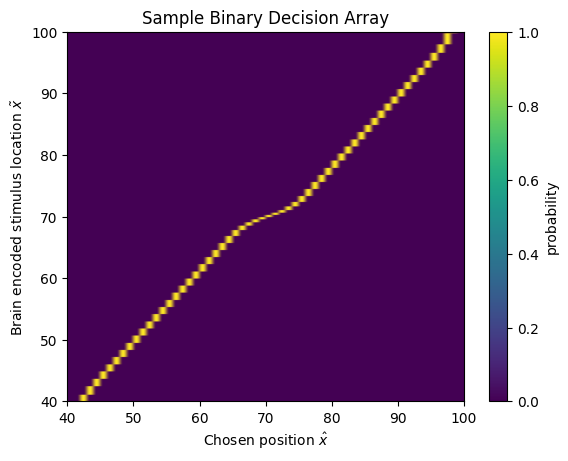

In [8]:
def calculate_binary_decision_array(x_points, posterior_array):

    binary_decision_array = np.zeros_like(posterior_array)

    for i in range(len(posterior_array)):
        # calculate mean of posterior using 'mean_median_mode'
        mean, _, _ = mean_median_mode(x_points, posterior_array[i])
        # find the postion of mean in x_points (closest position)
        idx = np.argmin(np.abs(x_points - mean))
        binary_decision_array[i, idx] = 1

    return binary_decision_array

binary_decision_array = calculate_binary_decision_array(x, posterior_array)

plot_array_heatmap(binary_decision_array,
               'Chosen position $\hat x$', 
               'Brain encoded stimulus location $\~x$',
               'Sample Binary Decision Array')

## (5) Function to generate the input array

- Now we have the best estimate ($\^x$) given an encoded/measured sitimulus ($\~x$). 
- In this step, we need to know how probable each $\~x$ is given the true stimulus x


<>:15: SyntaxWarning: invalid escape sequence '\~'
<>:16: SyntaxWarning: invalid escape sequence '\~'
<>:15: SyntaxWarning: invalid escape sequence '\~'
<>:16: SyntaxWarning: invalid escape sequence '\~'
C:\Users\beck\AppData\Local\Temp\ipykernel_21988\2390832559.py:15: SyntaxWarning: invalid escape sequence '\~'
  'Brain encoded stimulus location $\~x$',
C:\Users\beck\AppData\Local\Temp\ipykernel_21988\2390832559.py:16: SyntaxWarning: invalid escape sequence '\~'
  'Sample Distribution over Encodings:\n $p(\~x | x = 80)$')


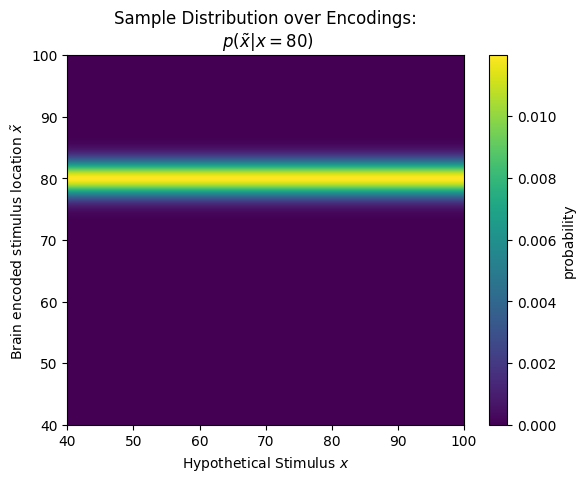

In [9]:
def generate_input_array(x_points, stim_array, posterior_array,
                         mean=80, sigma=2):

    input_array = np.zeros_like(posterior_array)

    for i in range(len(x_points)):
        input_array[:, i] = gaussian(stim_array, mean, sigma)

    return input_array

input_array = generate_input_array(x, hypothetical_stim, posterior_array)

plot_array_heatmap(input_array,
               'Hypothetical Stimulus $x$', 
               'Brain encoded stimulus location $\~x$',
               'Sample Distribution over Encodings:\n $p(\~x | x = 80)$')

## (6) Function for marginalization

- Based on a true stimulus (x_true)  and a way to link it to potential encodings/measurements, we can calculate the distribution of encodings and ultimately estimates.
- To integrate over all possible hypothetical values of  ($\~x$)  we marginalize; that is, we first compute the dot-product from the true presented stimulus and our binary decision array and then sum over x.

<>:12: SyntaxWarning: invalid escape sequence '\h'
<>:13: SyntaxWarning: invalid escape sequence '\~'
<>:14: SyntaxWarning: invalid escape sequence '\^'
<>:18: SyntaxWarning: invalid escape sequence '\h'
<>:12: SyntaxWarning: invalid escape sequence '\h'
<>:13: SyntaxWarning: invalid escape sequence '\~'
<>:14: SyntaxWarning: invalid escape sequence '\^'
<>:18: SyntaxWarning: invalid escape sequence '\h'
C:\Users\beck\AppData\Local\Temp\ipykernel_21988\1695330511.py:12: SyntaxWarning: invalid escape sequence '\h'
  'Estimated stimulus location $\hat x$',
C:\Users\beck\AppData\Local\Temp\ipykernel_21988\1695330511.py:13: SyntaxWarning: invalid escape sequence '\~'
  'Brain encoded stimulus location $\~x$',
C:\Users\beck\AppData\Local\Temp\ipykernel_21988\1695330511.py:14: SyntaxWarning: invalid escape sequence '\^'
  'Marginalization array: $p(\^x | \~x)$')
C:\Users\beck\AppData\Local\Temp\ipykernel_21988\1695330511.py:18: SyntaxWarning: invalid escape sequence '\h'
  plt.xlabel('Estima

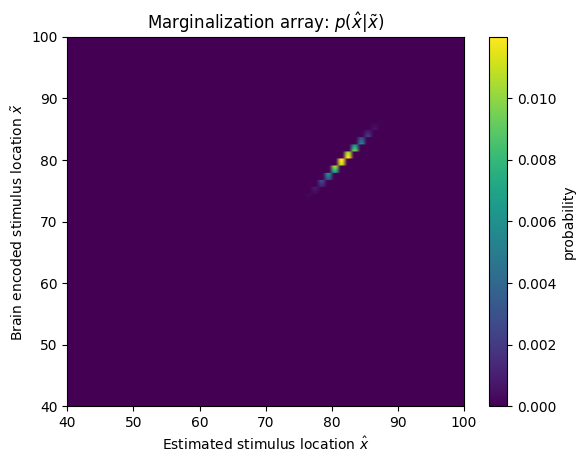

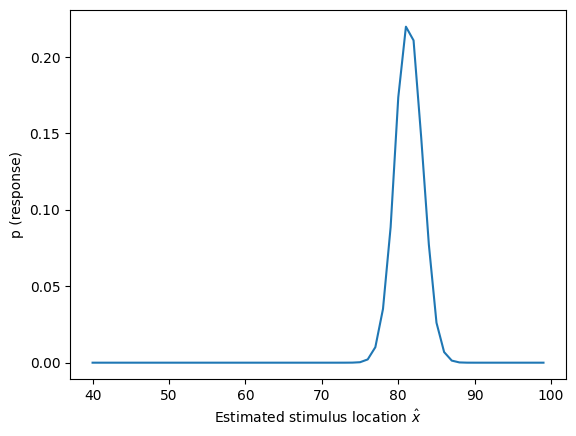

Mean of marginal: 81.37614240141282


In [10]:
def marginalization(input_array, binary_decision_array):

    marginalization_array = input_array * binary_decision_array
    marginal = np.sum(marginalization_array, axis=0)  # note axis
    marginal /= marginal.sum()  # normalize

    return marginalization_array, marginal

marginalization_array, marginal = marginalization(input_array, binary_decision_array)

plot_array_heatmap(marginalization_array, 
                   'Estimated stimulus location $\hat x$', 
                   'Brain encoded stimulus location $\~x$', 
                   'Marginalization array: $p(\^x | \~x)$')

plt.figure()
plt.plot(x, marginal)
plt.xlabel('Estimated stimulus location $\hat x$')
plt.ylabel('p (response)')
plt.show()

# mean of marginal
mean, _, _ = mean_median_mode(x, marginal)
print(f"Mean of marginal: {mean}")

# Simulate full tennis experiment

- Uses function to generate the prior array from (2)
- Loops through all experimental trials (i.e., through all x_trues)
    - For every trial, uses functions from (1-6) above to
        - generate a likelihood array
        - compute the posterior
        - marginalize to obtain a response estimate
- Saves the estimated responses for all trials

In [11]:
# define the prior
# use function from (2) above 
prior = calculate_bimodal_prior_array(x, hypothetical_stim)

# x_trues are the ball positions in the experiment (the true stimulus)
x_trues = experimental_protocol['ball_positions'].values
x_trues = np.array(x_trues)
  
# accumulate results here
estimated_response = []
  
# Loop through all trials of the experiment  
for i, x_true in enumerate(x_trues):
    
  sigma_likelihood = 1 # assumed SD of likelihood in condition "slow"

  if experimental_protocol.loc[i, 'condition'] == "slow":
    sigma_likelihood = sigma_likelihood * 1
  elif experimental_protocol.loc[i, 'condition'] == "moderate":
    sigma_likelihood = sigma_likelihood * 6
  elif experimental_protocol.loc[i, 'condition'] == "fast":
    sigma_likelihood = sigma_likelihood * 12
  else:
    print("did not read the speed-condition-column")
   
  # generate likelihood array using function from (1) above   
  likelihood_array = compute_likelihood_array(x, hypothetical_stim, sigma_likelihood)
  # multiply the prior and likelihood to obtain the posterior array using function from (3) above
  posterior_array = calculate_posterior_array(prior, likelihood_array)
  # calculate the binary decision array using function from (4) above
  binary_decision_array = calculate_binary_decision_array(x, posterior_array)
  # generate the input array using function from (5) above
  input_array = generate_input_array(x, hypothetical_stim, posterior_array, mean=x_true)
  # marginalize using function from (6) above
  marginalization_array, marginal = marginalization(input_array, binary_decision_array)
  # get the mean of the response distribution as the estimated response
  mean, _, _ = mean_median_mode(x, marginal)
  estimated_response.append(mean)

### Calculate a predicted "estimation error" for every trial and save in **`predicted_responses` dataframe:** 


- **Estimation error:**  
  For each trial, compute 

  $
  \text{estimation error} = \text{true ball position} - \text{predicted response}
  $  


In [12]:
predicted_responses = pd.DataFrame({'trial_id': experimental_protocol['trial_id'],
                                     'condition': experimental_protocol['condition'],
                                     'ball_positions': experimental_protocol['ball_positions'],
                                     'estimated_response': estimated_response})

# Calculate the estimation error: diff between ball position and estimated response
predicted_responses['estimation_error'] = predicted_responses['ball_positions'] - predicted_responses['estimated_response']

## Plot Bayesian predictions: Estimation Error vs. Ball positions as a function of the uncertainty condition (slow/moderate/fast)

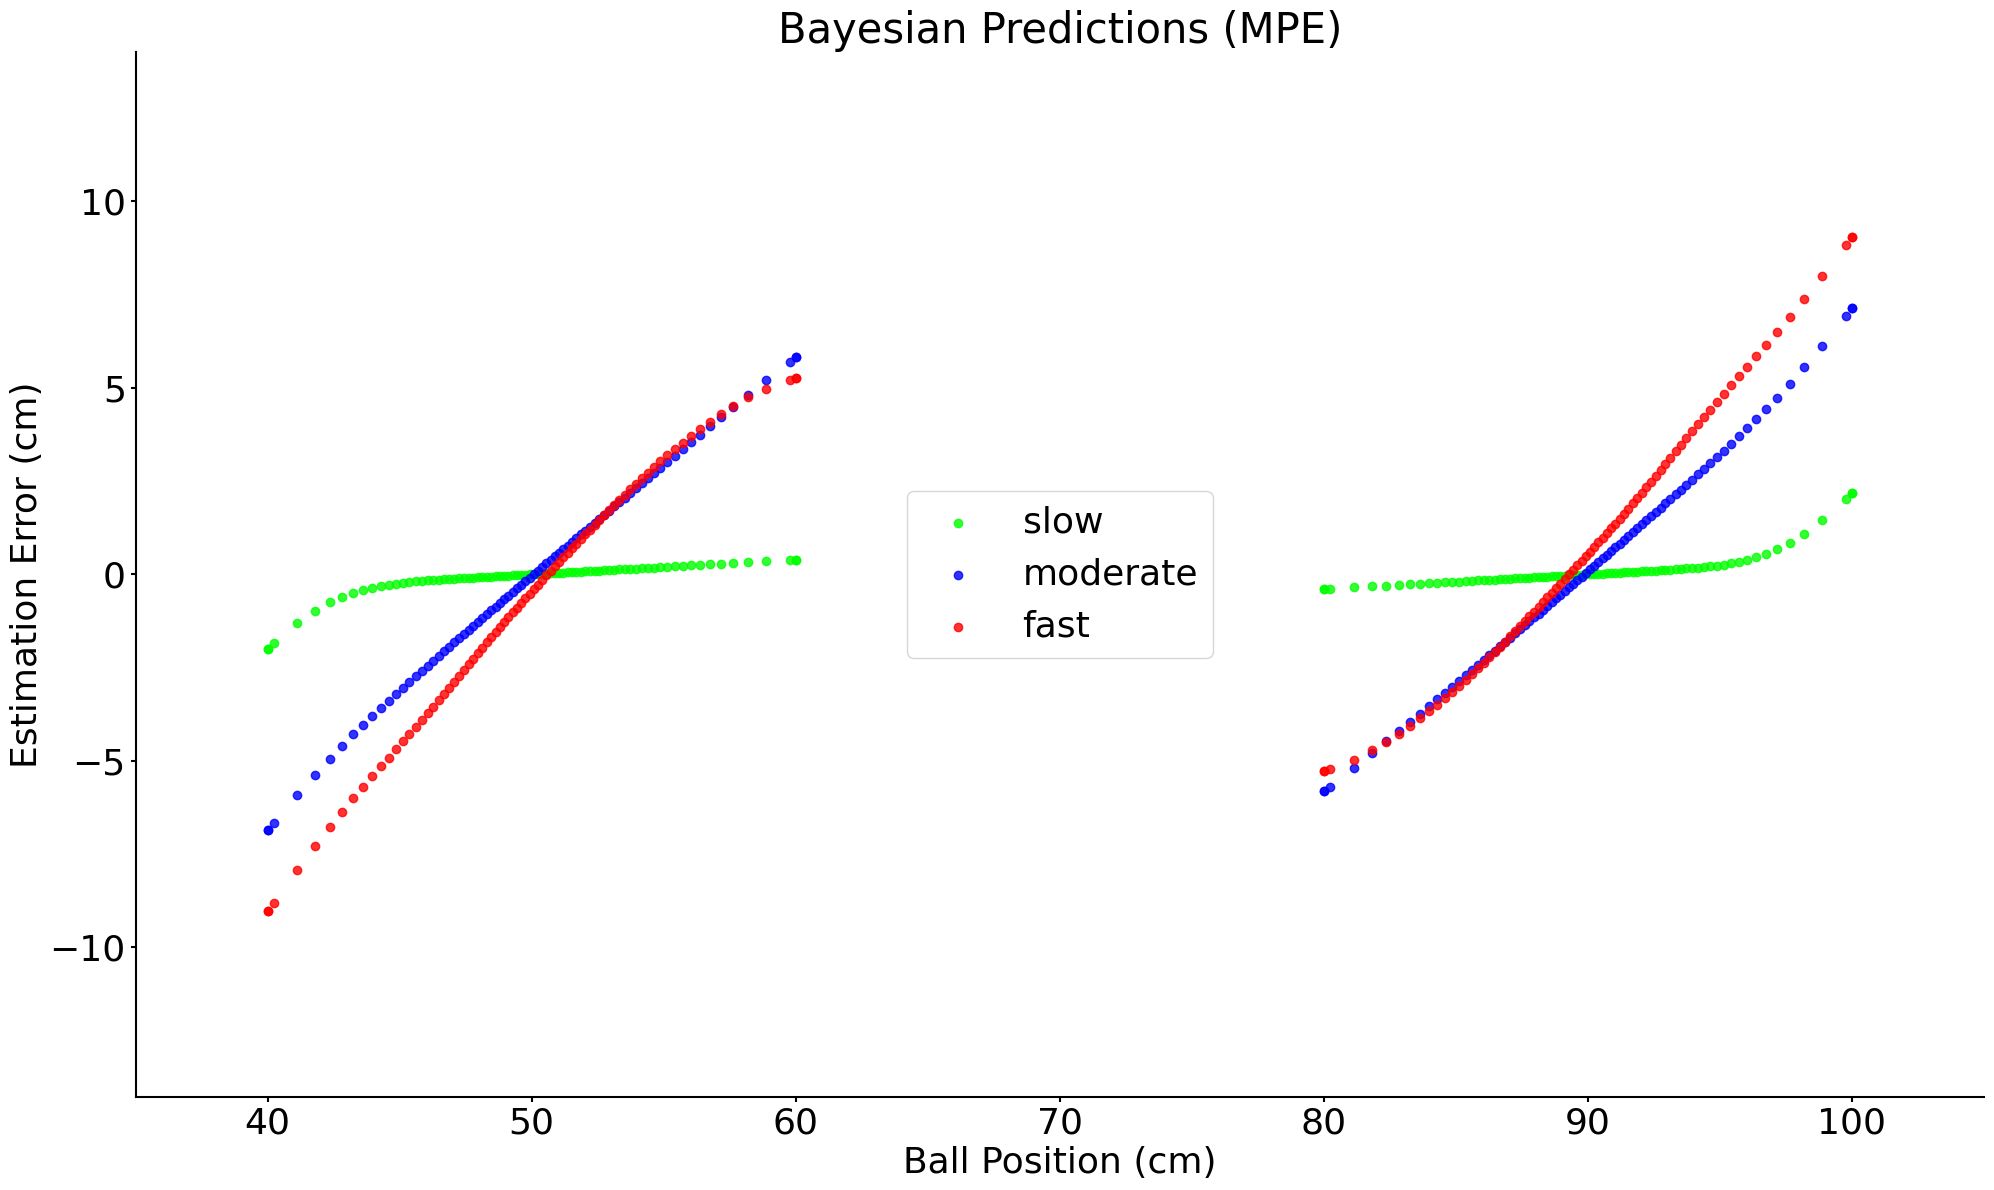

In [13]:
# Map conditions to colors
condition_colors = {
    'fast': 'red',
    'moderate': 'blue',
    'slow': '#00FF00'
}

# Create plot of the predicted responses
plot_3_uncertainty_levels = sns.lmplot(x='ball_positions', y='estimation_error', hue='condition', palette=condition_colors, data=predicted_responses, legend = False, fit_reg=False,
    height=12,  # Height in inches
    aspect=1.67)

# Limit y and x axis
plot_3_uncertainty_levels.set(ylim=(-14, 14))
plot_3_uncertainty_levels.set(xlim=(35, 105))

# Set axis labels
plot_3_uncertainty_levels.set_ylabels('Estimation Error (cm)', fontsize=26)
plot_3_uncertainty_levels.set_xlabels('Ball Position (cm)', fontsize=26)

# Aesthetics
# Font size of ticks
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)

# Thickness of axes lines
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.tick_params(width=1.5)

# Add lend and title
plt.legend(loc='center', bbox_to_anchor=(0.5, 0.5), fontsize=26)
plt.title('Bayesian Predictions (MPE)', fontsize=30)
    

# Adjust layout to prevent cutting off labels
plt.tight_layout()

plt.savefig('prediction_plot.png', dpi=300)
plt.savefig('prediction_plot.svg')

-----------
# Combined model: Bayesian predictions + biomechanical costs

Based on empirical data of a control experiment (N= 24), we develop a model that combines the effect of the acquired bimodal prior (Bayesian simulations so far) and a systematic bias caused by biomechanical costs.

Steps:
- read regression parameters (intercept and slope) from the control experiment (from data folder)
- correct predicted responses for each trial with an additive bias derived form the regression parameters depended on the ball speed condition

In [14]:
# read fixed effects from the subfolder "data"
fixed_effects_control = pd.read_csv('../data/fixed_effects_control.csv')

# check
fixed_effects_control.head()

,Condition,Intercept,Slope_Ball_Position
0,Fast,-31.494426,0.373553
1,Moderate,-14.742399,0.183402
2,Slow,6.218875,-0.025874


In [15]:
predicted_responses = pd.DataFrame({'trial_id': experimental_protocol['trial_id'],
                                     'condition': experimental_protocol['condition'],
                                     'ball_positions': experimental_protocol['ball_positions'],
                                     'estimated_response': estimated_response})

# Calculate the estimation error: diff between ball position and estimated response
predicted_responses['estimation_error'] = predicted_responses['ball_positions'] - predicted_responses['estimated_response']

# prepare new columns
predicted_responses['estimated_response_corrected'] = predicted_responses['estimation_error']

# loop and correct each prediction using the matching fixed effects
for i, row in predicted_responses.iterrows():
    if row["condition"] == "slow":
        correction = fixed_effects_control.loc[fixed_effects_control['Condition'] == 'Slow', 'Intercept'] + fixed_effects_control.loc[fixed_effects_control['Condition'] == 'Slow', "Slope_Ball_Position"] * row['ball_positions']
        predicted_responses.at[i, 'estimated_response_corrected'] = row['estimation_error'] + correction
    elif row["condition"] == "moderate":
        correction = fixed_effects_control.loc[fixed_effects_control['Condition'] == 'Moderate', 'Intercept'] + fixed_effects_control.loc[fixed_effects_control['Condition'] == 'Moderate', "Slope_Ball_Position"] * row['ball_positions']
        predicted_responses.at[i, 'estimated_response_corrected'] = row['estimation_error'] + correction
    elif row["condition"] == "fast":
        correction = fixed_effects_control.loc[fixed_effects_control['Condition'] == 'Fast', 'Intercept'] + fixed_effects_control.loc[fixed_effects_control['Condition'] == 'Fast', "Slope_Ball_Position"] * row['ball_positions']
        predicted_responses.at[i, 'estimated_response_corrected'] = row['estimation_error'] + correction
    else:
        print("Condition not recognized.") 

C:\Users\beck\AppData\Local\Temp\ipykernel_21988\3706618950.py:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  predicted_responses.at[i, 'estimated_response_corrected'] = row['estimation_error'] + correction
C:\Users\beck\AppData\Local\Temp\ipykernel_21988\3706618950.py:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  predicted_responses.at[i, 'estimated_response_corrected'] = row['estimation_error'] + correction
C:\Users\beck\AppData\Local\Temp\ipykernel_21988\3706618950.py:22: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  predicted_responses.at[i, 'estimated_response_corrected'] = row['estimation_error'] + correction


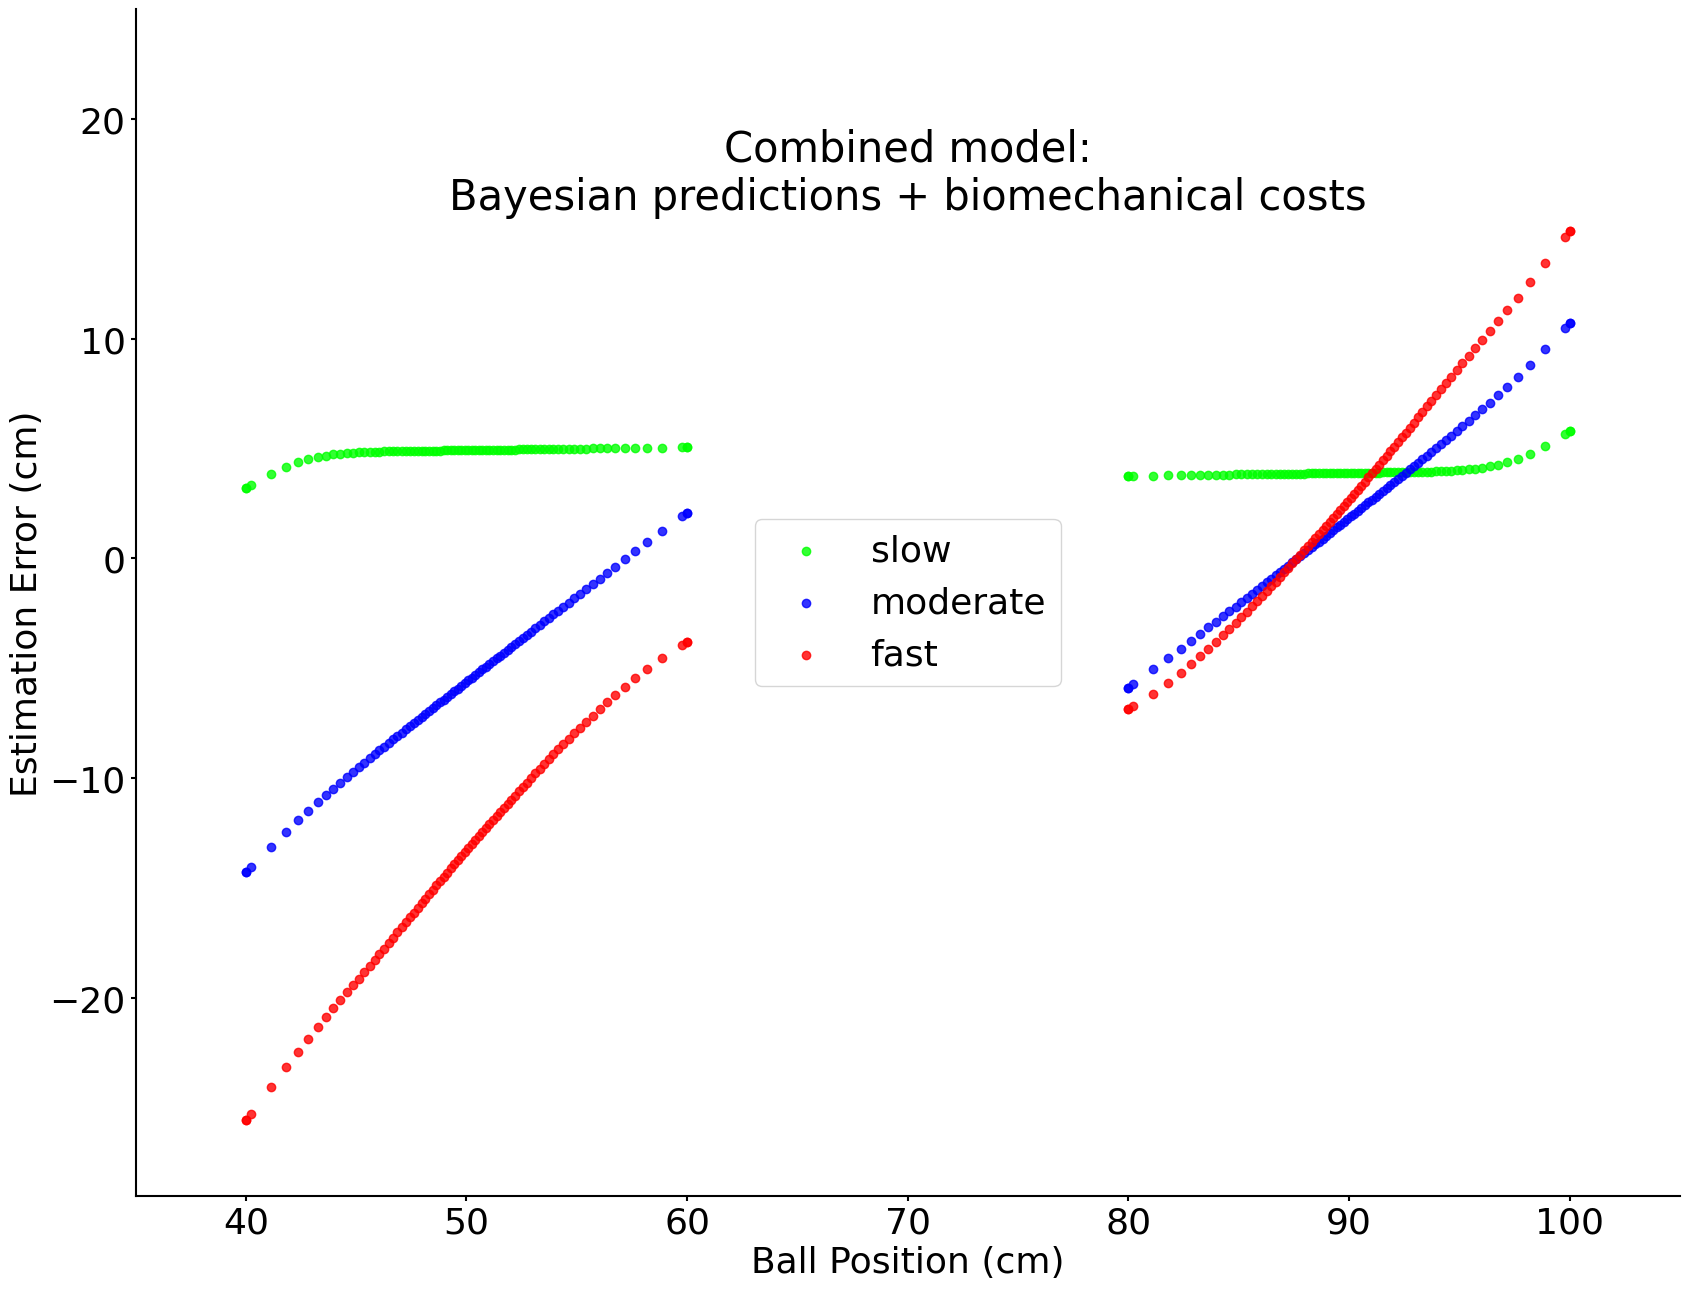

In [16]:
# Map conditions to colors
condition_colors = {
    'fast': 'red',
    'moderate': 'blue',
    'slow': '#00FF00'
}

# Create plot of the predicted responses
plot_3_uncertainty_levels = sns.lmplot(x='ball_positions', y='estimated_response_corrected', hue='condition', palette=condition_colors, data=predicted_responses, legend = False, fit_reg=False,
    height=13,  # Height in inches
    aspect=17/13)

# Limit y and x axis
plot_3_uncertainty_levels.set(ylim=(-29, 25))
plot_3_uncertainty_levels.set(xlim=(35, 105))

# Set axis labels
plot_3_uncertainty_levels.set_ylabels('Estimation Error (cm)', fontsize=26)
plot_3_uncertainty_levels.set_xlabels('Ball Position (cm)', fontsize=26)

# Aesthetics
# Font size of ticks
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)

# Thickness of axes lines
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.tick_params(width=1.5)

# Add lend and title
plt.legend(loc='center', bbox_to_anchor=(0.5, 0.5), fontsize=26)
#plt.title('Combined model:\n Bayesian predictions + biomechanical costs', fontsize=30, y = 1)

# Add legend
plt.legend(loc='center', bbox_to_anchor=(0.5, 0.5), fontsize=26)

# Add title
ax = plot_3_uncertainty_levels.axes[0,0]
ax.text(
    0.5, 0.9, 
    'Combined model:\nBayesian predictions + biomechanical costs',
    transform=ax.transAxes,
    ha='center', va='top',
    fontsize=30
)
    
# Adjust layout to prevent cutting off labels
plt.tight_layout()

plt.savefig('prediction_plot_corrected.png', dpi=300)
plt.savefig('prediction_plot_corrected.svg')